In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas
import scipy.io as sio
import os
import networkx as nx
import community as community_louvain
import pickle
import itertools 
from functions_analaysis_connectivity import *
import matplotlib as mt
from matplotlib.colors import LogNorm
from sklearn.linear_model import LinearRegression
import matplotlib
import matplotlib.patches as patches
import scipy.io as sio
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [4]:
path = 'data_connectivity/'
#loading tractograpy
tract = sio.loadmat(path+'FSe_tractography.mat')
cortex_acr = [tract['area_list_Sean_89'][0][l][0] for l in range(89)] 
dist = 10**(tract['FSe_tractography_Sean_order'])
mat = 10**(tract['FSe_tractography_Sean_order'])
hier_tract =sio.loadmat(path+'hierarchy_89_areas.mat')
sln_pred = sio.loadmat(path+'sln_real_and_pred.mat')
t1_t2 = sio.loadmat(path+'myelin_hierarchy_order.mat')
ind_t1_t2 = np.argsort(-t1_t2['myelin_hierarchy_order'][:,0])
t1_t2_val = t1_t2['myelin_hierarchy_order'][:,0] # value t1/t2
coords_data = sio.loadmat(path +'central_vertex_coords.mat')
coords = coords_data['central_vertex_coords']

spines27  = sio.loadmat(path+'spine_data_27.mat')
h_tract = np.array([x for x in hier_tract['hierarchy_vals_fullgraph'][:,0]])
# loading kennedy's data
con_ken = sio.loadmat(path+'beta_bin_hierarchy_subgraph.mat')
acr_ken = [con_ken['subgraph_hierarchical_order'][l][0][0] for l in range(40)]
mat_ken = con_ken['HierOrderedFLNsubgraph']
sln_ken = con_ken['HierOrderedSLNsubgraph']
#loading spine count
spines = np.array([x for x in sio.loadmat(path+'spines_inferred.mat')['spine_count_40'][:,0]])

<p style="font-size: 26px;">Loading clusters computed using louvain algorithm on tractography data</p>


In [5]:
# difusssion map data
psi = diffussion_map(dist)
rank, ind_rank, acr_rank = euclidian_distance(psi, cortex_acr, 'V1')

#community discovery analysis
if False:
    mat_com = realizations_louvain(mat, 10000)
    pickle.dump(mat_com, open('generated_data/clusters_louvain.p','wb'))
mat_com = pickle.load(open('generated_data/clusters_louvain.p','rb'))   

<p style="font-size: 26px;">Plotting tractography matrix</p>

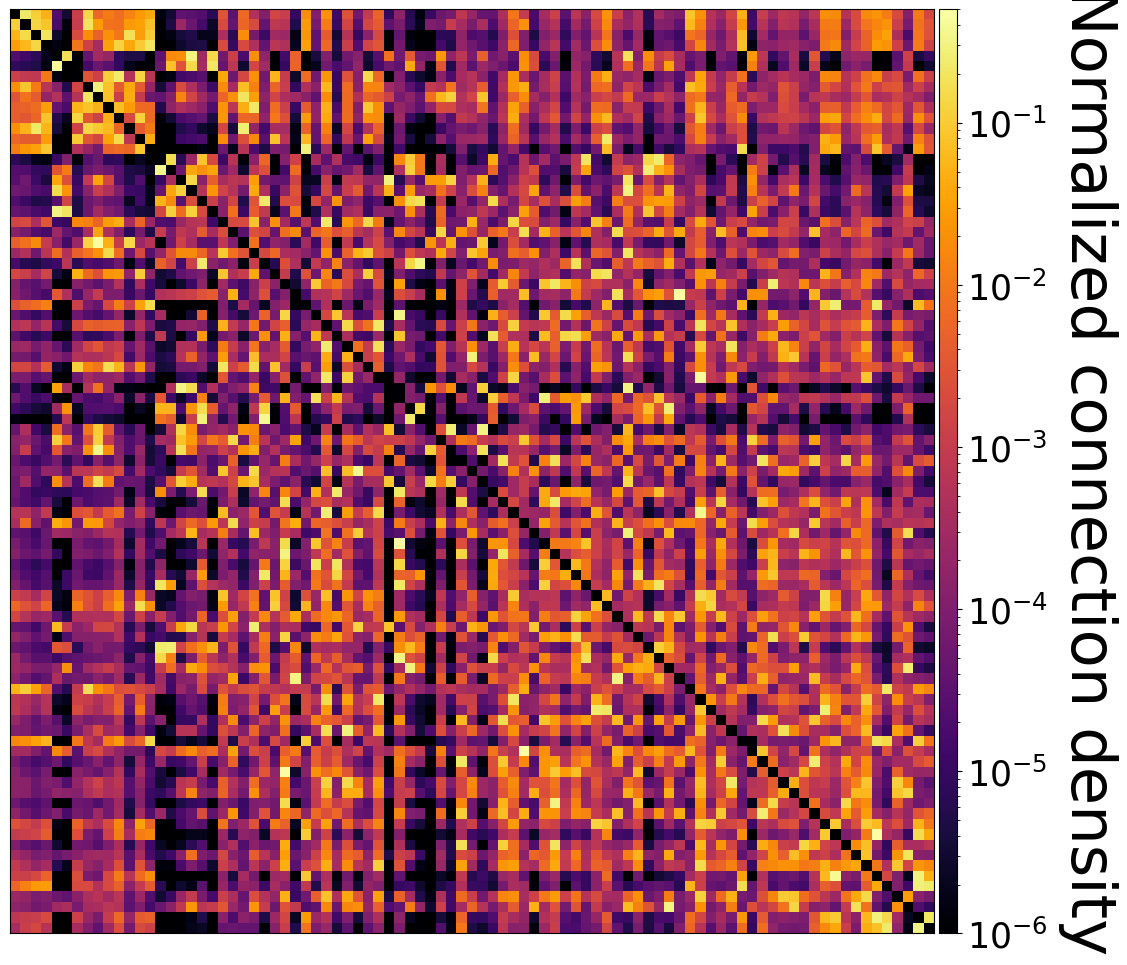

In [4]:
#cortico_thalamic = np.array([mat[thal_ind_fine[ind_rank_thal[l]],ind_selected_areas] for l in range(40)])
bel_size =20
tick_size = 20
cbar_tick_size = 25
fig = plt.figure(figsize = (20,12))
plt.subplots_adjust(hspace = 0.4,wspace = 0.3)

ax = fig.add_subplot(111)
im1 = ax.imshow(mat,norm=LogNorm(vmin=1e-6, vmax=.5), cmap='inferno')
ax.set_xticks([])
ax.set_yticks([])
#ax.set_xticklabels(acr_rank_thal, rotation = 90)
ax.tick_params(axis='both', which='major', labelsize=tick_size)


# Add the patch to the Axes
#rect = patches.Rectangle((40-.8, 45-.8), 1.5, 1.5, linewidth=5, edgecolor='g', facecolor='none')

#ax.add_patch(rect)


#ax.set_yticks(np.arange(0,mat_selected.shape[0],1))
#ax.set_yticklabels(selected_areas)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='2%', pad=0.05)
cbar = fig.colorbar(im1,cax=cax, orientation='vertical')
cbar.set_label('Normalized connection density', rotation=270, fontsize  = 45,labelpad=50)
cbar.ax.tick_params(labelsize=cbar_tick_size) 
#ax.set_ylabel('Surce region Cortex',fontsize = label_size)
#ax.set_xlabel('Target region Thalamus',fontsize = label_size)
#ax.set_title('Corticothalamic projections', fontsize = label_size, y= 1.02)
#plt.savefig('figures/fig1A.pdf',bbox_inches = 'tight',transparent = True)


<p style="font-size: 26px;">Plotting tractography on difussion space with clusters</p>

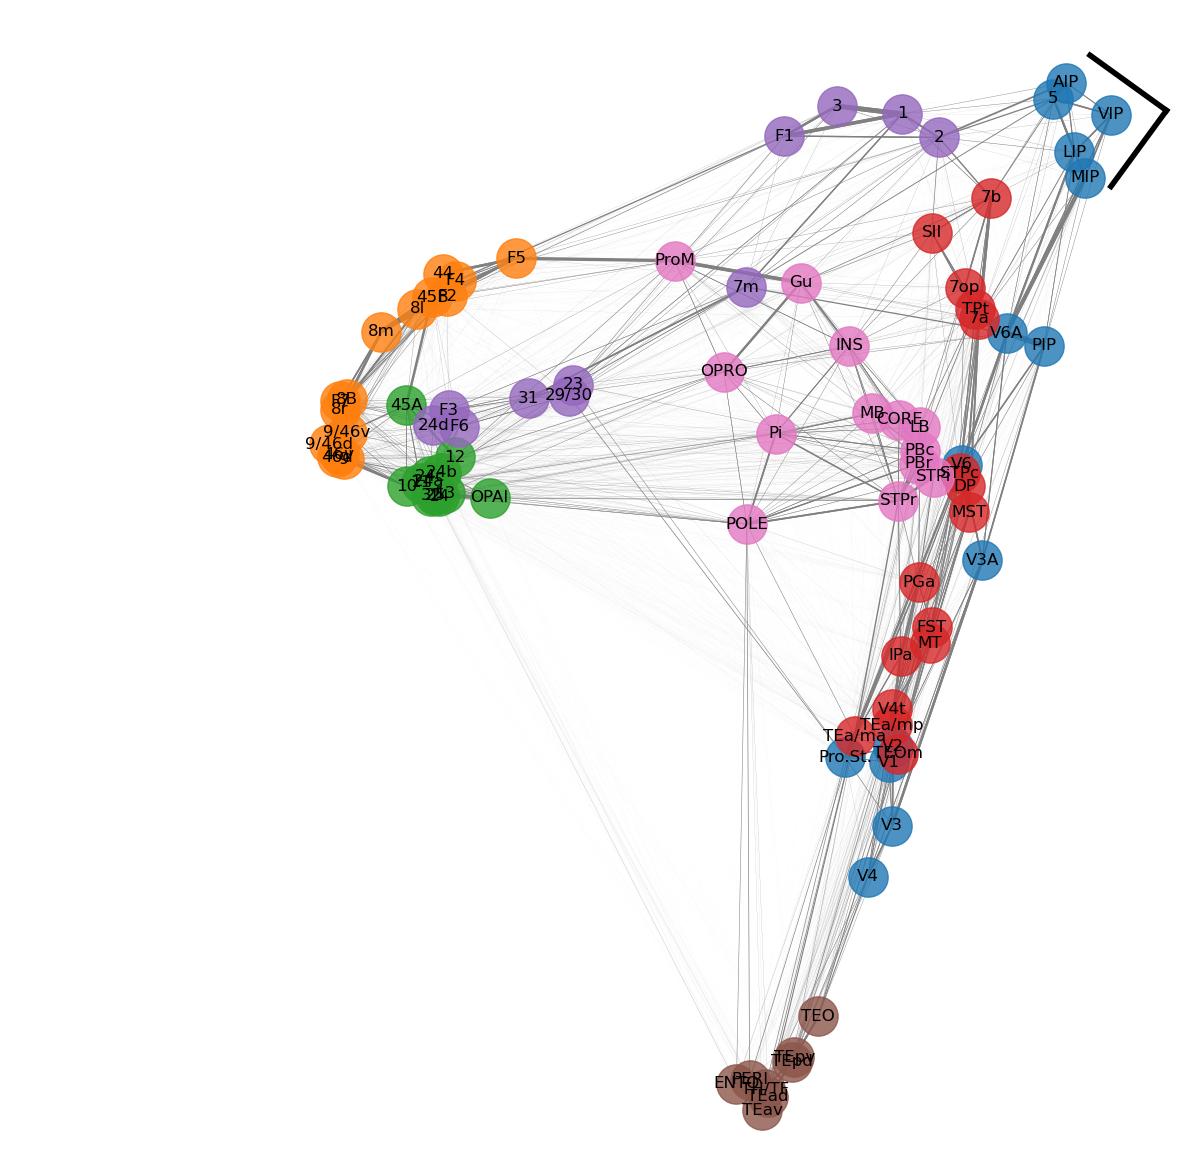

In [5]:
t= 0 
mat_ord = mat#np.arrange([[mat[i,j] for j in ind_rank] for i in ind_rank])
G = nx.from_numpy_array(mat_ord)
#partition = community_louvain.best_partition(G)
partition = louvain(mat_com)
edges = G.edges()


rotation = lambda x: np.array([[np.cos(x), -np.sin(x)], [np.sin(x), np.cos(x)]])
psi_rot = lambda x:np.einsum('ij,lj->li', rotation(x), psi(t)[:, 1:3])



theta =   (4 * np.pi)/5.



pos = {}
for l in range(89):
    #pos[l]= (psi(t)[l,1].real,psi(t)[l,2].real)  # positions for all nodes
    pos[l]= (psi_rot(theta)[l, 0].real, psi_rot(theta)[l,1].real) 
M = G.number_of_edges()

origin_x = -.07
origin_y = -.26
x = np.array([np.linspace(0, .04, 1000) + origin_x, origin_y *  np.ones(1000)]) 
y = np.array([ origin_x * np.ones(1000), np.linspace(0, .04, 1000) + origin_y ]) 

x_axis = np.einsum('ij,jl->li',rotation(theta), x) 
y_axis = np.einsum('ij,jl->li',rotation(theta), y) 



fig, ax = plt.subplots(figsize = (15,15))

# nodes
all_nodes = [x for x in range(89)]
#colors = plt.cm.tab10()
#colors = ['b','r','g','m','c','orange','cyan','y','gray','k']
count = 0
for com in set(partition.values()) :
    count = count + 1
    list_nodes = [int(nodes) for nodes in partition.keys() if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 800, node_color =  [plt.cm.tab10(count-1)], alpha = 0.8)
    list_edges = [x for x in itertools.product(all_nodes,list_nodes)]
    all_nodes = [x for x in all_nodes if x not in list_nodes]
    weights = [4 * (G[u][v]['weight']-np.min(mat))/(np.max(mat)-np.min(mat)) for u,v in list_edges]
    nx.draw_networkx_edges(G,pos,edgelist=list_edges,width=weights,edge_color='gray')

#nx.draw_networkx_edges(G, pos,
 #   width=weights *4
                               
#)
#edges[0].set_alpha(1)

# some math labels
labels = {}
for l in range(0,89):
    labels[l] = cortex_acr[l]

nx.draw_networkx_labels(G, pos, labels, font_size=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
x_min = np.min(psi(t)[:,1].real)
x_max = np.max(psi(t)[:,1].real)
ax.set_xlim([-.28, .212])
ax.set_ylim([-.28, .212])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.plot(x_axis[:, 0], x_axis[:, 1], color = 'k', lw = 4)
ax.plot(y_axis[:, 0], y_axis[:, 1], color = 'k', lw = 4)


#ax.set_title('Tractography  macaque monkey', fontsize = 30, y=1.02)
#plt.savefig('figures/fig1_B.png',bbox_inches = 'tight')

In [7]:
com = 3
#0, 2, 3
ind_areas_interest = []
ind_areas_frontal = []
for com in range(10):
    if com in [0,2,3]:
        list_nodes = [int(nodes) for nodes in partition.keys() if partition[nodes] == com]
        ind_areas_interest = ind_areas_interest + list_nodes        
    else:
        list_nodes_frontal = [int(nodes) for nodes in partition.keys() if partition[nodes] == com]
        ind_areas_frontal = ind_areas_frontal + list_nodes_frontal


frontal_acr = []
for i in ind_areas_frontal:
    #print(cortex_acr[i])
    frontal_acr.append(cortex_acr[i])



t = 0
psi_x = []
psi_y = []
for l in ind_areas_frontal:
    psi_x.append(psi(t)[l,1].real)
    psi_y.append(psi(t)[l,2].real)
psi_x = np.array(psi_x)
psi_y = np.array(psi_y)

psi_x = psi_x.reshape(-1, 1)
psi_y = psi_y.reshape(-1, 1)
reg_frontal = LinearRegression().fit(psi_x, psi_y)





t = 0
xi_x = []
xi_y = []
for l in ind_areas_interest:
    xi_x.append(psi(t)[l,1].real)
    xi_y.append(psi(t)[l,2].real)
xi_x = np.array(xi_x)
xi_y = np.array(xi_y)
xi_x = xi_x.reshape(-1, 1)
xi_y = xi_y.reshape(-1, 1)
reg_interest = LinearRegression().fit(xi_x, xi_y)



#interesection of the frontal and dorsal-ventral axis
x_origin = (reg_frontal.intercept_ - reg_interest.intercept_)/(reg_interest.coef_[0] - reg_frontal.coef_[0])
y_origin =  reg_frontal.coef_[0]* x_origin + reg_frontal.intercept_
origin = np.array([x_origin[0], y_origin[0]])

fun_interest = lambda y: reg_interest.coef_[0]* y + reg_interest.intercept_
fun_frontal= lambda y: reg_frontal.coef_[0]* y + reg_frontal.intercept_
axis_interest = np.array([-.15 - x_origin[0],fun_interest(-.15)[0] - y_origin[0] ])
axis_interest  = axis_interest

axis_frontal = np.array([.15 - x_origin[0],fun_frontal(.15)[0] - y_origin[0]])
axis_frontal  = axis_frontal

u1 = axis_interest-origin
const = np.dot(axis_frontal-origin,u1)/(np.dot(u1,u1))
u2 = axis_frontal-origin - const * axis_interest 

int_norm = axis_interest/np.linalg.norm(axis_interest)
frontal_norm = axis_frontal/np.linalg.norm(axis_frontal)

x_axis_origin = np.array([1,0])-origin
x_axis_origin = x_axis_origin/np.linalg.norm(x_axis_origin)
rotation = lambda x: np.array([[np.cos(x), -np.sin(x)], [np.sin(x), np.cos(x)]])
ang_rotation = np.arccos(np.dot(int_norm, x_axis_origin))

psi_org =psi(t)[:, 1:3]- np.outer(np.ones(89), origin)
psi_org =np.array([psi_org[l,:].real for l in range(psi_org.shape[0])])
psi_rot = lambda x:np.einsum('ij,lj->li', rotation(x), psi_org)
psi_new = psi_rot(-ang_rotation)



# projections on the axis of interest
proj_areas_interest = []
for l in range(89):
    proj_areas_interest.append(int_norm.dot(psi_org[l,:]) * int_norm + origin)
proj_areas_interest = np.array(proj_areas_interest)



# projections on the axis of interest
proj_frontal = []
for l in range(89):
    proj_frontal.append(frontal_norm.dot(psi_org[l,:]) * frontal_norm + origin)
proj_frontal = np.array(proj_frontal)


org = np.array([x_origin[0], y_origin[0]])

#distance in the visual axis
v1 = axis_interest - org # proj_areas_interest[cortex_acr.index('V1'),:] 
v1 = v1/np.linalg.norm(v1)
val_areas_interest = proj_areas_interest -   org.transpose()# proj_areas_interest[cortex_acr.index('V1'),:] 
distance_to_v1 = val_areas_interest.dot(v1) 
#pickle.dump(distance_to_v1, open('../connectivity_data/distance_ventral_dorsal_axis.p', 'wb'))


#minimum frontal axis

frontal_axis_min = axis_frontal - org
frontal_axis_min = frontal_axis_min/np.linalg.norm(frontal_axis_min)
val_areas_frontal = proj_frontal -  org.transpose()
distance_to_frontal= val_areas_frontal.dot(frontal_axis_min ) 
#pickle.dump(distance_to_frontal, open('../connectivity_data/distance_frontal_axis.p', 'wb'))
np.arccos(v1.dot(frontal_axis_min)) * (180/(np.pi))


sorted_dist_dv = []
sorted_acr_dv = []
sorted_ind_dv = []
for val in np.sort(distance_to_v1):
    ind = np.where(val==distance_to_v1)[0][0]
    if ind in ind_areas_interest: 
        sorted_dist_dv.append(val)
        sorted_acr_dv.append(cortex_acr[ind])
        sorted_ind_dv.append(ind)
sorted_dist_dv = np.array(sorted_dist_dv)
sorted_dist_dv = (sorted_dist_dv - np.min(sorted_dist_dv))/(np.max(sorted_dist_dv)- np.min(sorted_dist_dv))

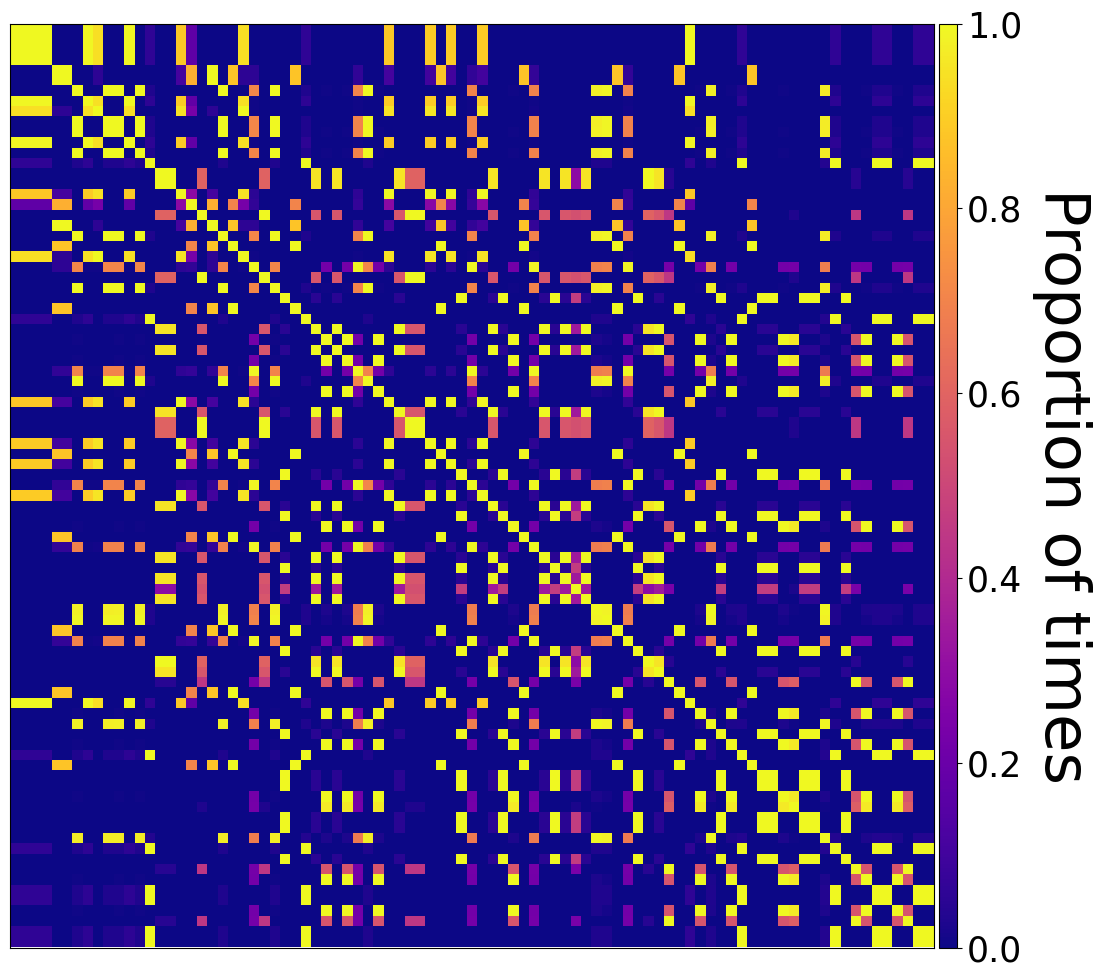

In [6]:
#cortico_thalamic = np.array([mat[thal_ind_fine[ind_rank_thal[l]],ind_selected_areas] for l in range(40)])
bel_size =20
tick_size = 20
cbar_tick_size = 25
fig = plt.figure(figsize = (20,12))
plt.subplots_adjust(hspace = 0.4,wspace = 0.3)

ax = fig.add_subplot(111)
im1 = ax.imshow(mat_com, cmap='plasma')
ax.set_xticks([])
ax.set_yticks([])
#ax.set_xticklabels(acr_rank_thal, rotation = 90)
ax.tick_params(axis='both', which='major', labelsize=tick_size)


# Add the patch to the Axes
#rect = patches.Rectangle((40-.8, 45-.8), 1.5, 1.5, linewidth=5, edgecolor='g', facecolor='none')

#ax.add_patch(rect)


#ax.set_yticks(np.arange(0,mat_selected.shape[0],1))
#ax.set_yticklabels(selected_areas)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='2%', pad=0.05)
cbar = fig.colorbar(im1,cax=cax, orientation='vertical')
cbar.set_label('Proportion of times', rotation=270, fontsize  = 45,labelpad=50)
cbar.ax.tick_params(labelsize=cbar_tick_size) 
#ax.set_ylabel('Surce region Cortex',fontsize = label_size)
#ax.set_xlabel('Target region Thalamus',fontsize = label_size)
#ax.set_title('Corticothalamic projections', fontsize = label_size, y= 1.02)
plt.savefig('figures/S1A.pdf',bbox_inches = 'tight',transparent = True)


-1.4713469743728638 -0.9726684093475342


(-0.28, 0.212)

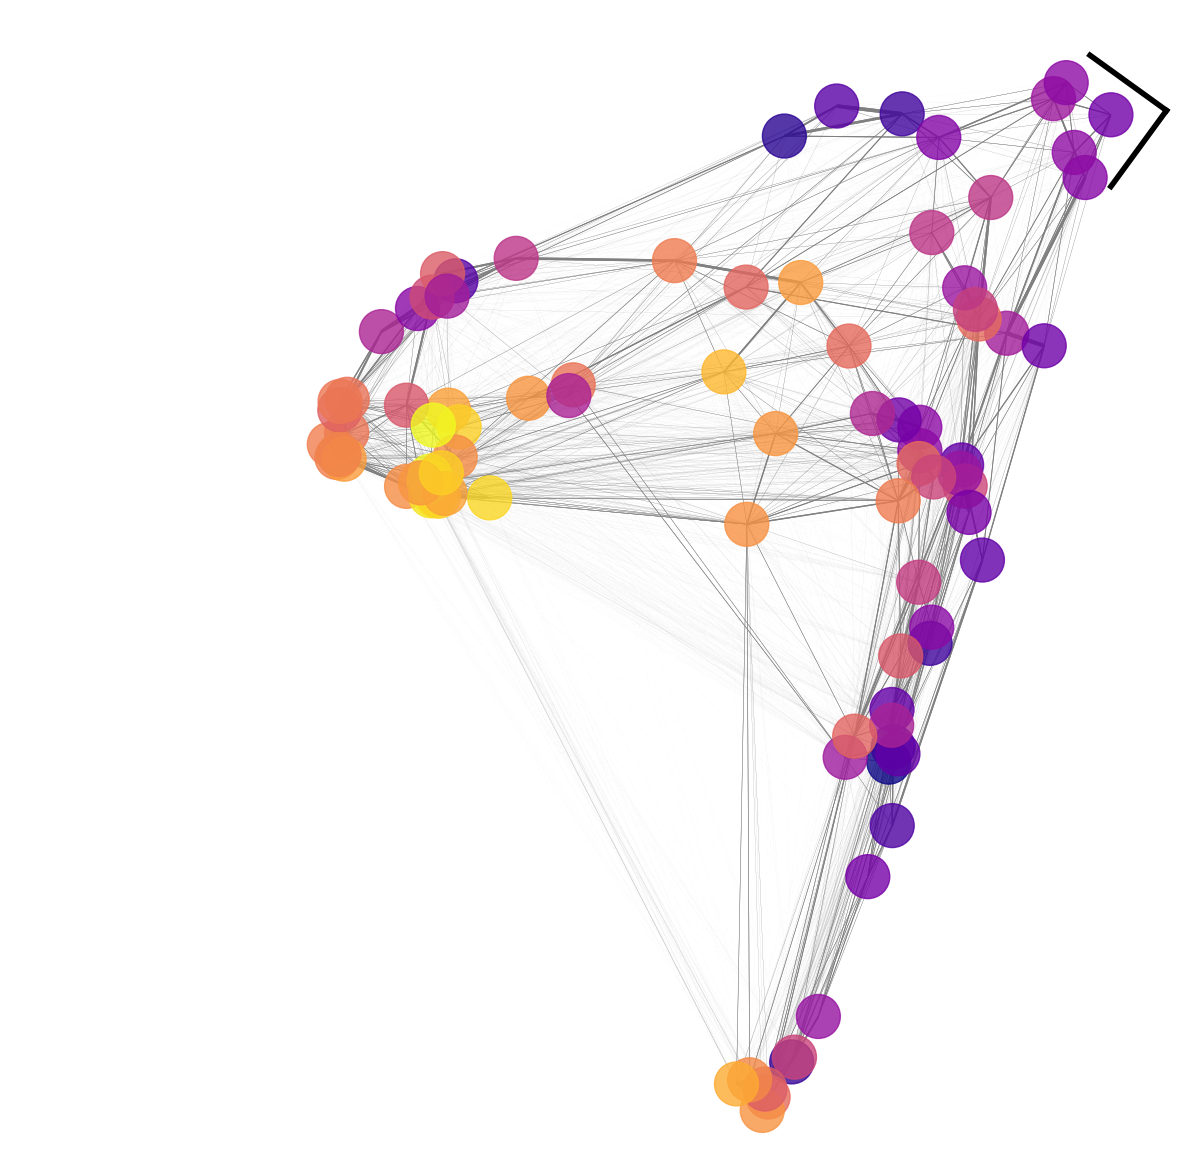

In [7]:

from matplotlib.transforms import Affine2D
import mpl_toolkits.axisartist.floating_axes as floating_axes

colors = plt.cm.jet(np.linspace(0,1,89))

t= 0 
mat_ord = mat#np.arrange([[mat[i,j] for j in ind_rank] for i in ind_rank])
G = nx.from_numpy_array(mat_ord)
#partition = community_louvain.best_partition(G)
partition = louvain(mat_com)
edges = G.edges()


rotation = lambda x: np.array([[np.cos(x), -np.sin(x)], [np.sin(x), np.cos(x)]])
psi_rot = lambda x:np.einsum('ij,lj->li', rotation(x), psi(t)[:, 1:3])



theta =   (4 * np.pi)/5.



pos = {}
for l in range(89):
    #pos[l]= (psi(t)[l,1].real,psi(t)[l,2].real)  # positions for all nodes
    pos[l]= (psi_rot(theta)[l, 0].real, psi_rot(theta)[l,1].real) 
M = G.number_of_edges()

origin_x = -.07
origin_y = -.26
x = np.array([np.linspace(0, .04, 1000) + origin_x, origin_y *  np.ones(1000)]) 
y = np.array([ origin_x * np.ones(1000), np.linspace(0, .04, 1000) + origin_y ]) 

x_axis = np.einsum('ij,jl->li',rotation(theta), x) 
y_axis = np.einsum('ij,jl->li',rotation(theta), y) 


fig, ax = plt.subplots(figsize = (15,15))

# nodes
all_nodes = [x for x in range(89)]
#colors = ['b','r','g','m','c','orange','cyan','y','gray','k']
count = 0

list_nodes = [x for x in range(89)]
nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 1000, node_color = -t1_t2_val, alpha = 0.8, cmap=plt.cm.plasma)
list_edges = [x for x in itertools.product(all_nodes,list_nodes)]
weights = [3 * (G[u][v]['weight']-np.min(mat))/(np.max(mat)-np.min(mat)) for u,v in list_edges]
nx.draw_networkx_edges(G,pos,edgelist=list_edges,width=weights,edge_color='gray')

#nx.draw_networkx_edges(G, pos,
 #   width=weights *4
                               
#)
#edges[0].set_alpha(1)

# some math labels
#labels = {}
#for l in range(0,89):
#    labels[l] = cortex_acr[l]
#nx.draw_networkx_labels(G, pos, labels, font_size=12)
#ax.set_xlabel('Gradient 1', fontsize = 30)
#ax.set_ylabel('Gradient 2', fontsize = 30)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

x_min = np.min(psi(t)[:,1].real)
x_max = np.max(psi(t)[:,1].real)
#ax.set_xlim([ x_min-.02, x_max+0.02])
#ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

vmin = np.min(-t1_t2_val)
vmax = np.max(-t1_t2_val)
print(vmin, vmax)


#sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma, norm=plt.Normalize(vmin = vmin, vmax=vmax))
#sm._A = []
#fig.colorbar(sm)

ax.plot(x_axis[:, 0], x_axis[:, 1], color = 'k', lw = 4)
ax.plot(y_axis[:, 0], y_axis[:, 1], color = 'k', lw = 4)


ax.set_xlim([-.28, .212])
ax.set_ylim([-.28, .212])
#ax.set_yticks([-0.1,0,0.1, .2])
#ax.set_yticklabels([-0.1,0,0.1, .2])
#ax.tick_params(axis='both', which='major', labelsize=22)

#ax.set_title('Tractography  macaque monkey', fontsize = 30, y=1.02)
#plt.savefig('figures/tractography_difussion_map_2D_t1_t2.png',bbox_inches = 'tight', transparent = True, dpi=150)

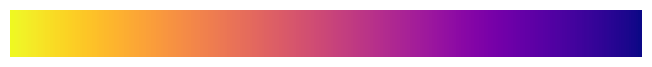

In [10]:
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
fig, axes = plt.subplots(figsize=(8,.5))
fig.subplots_adjust(top=0.95, bottom=0.01, left=0.2, right=0.99)
axes.imshow(-gradient, aspect='auto', cmap=plt.get_cmap('plasma'))
axes.set_axis_off()
#plt.savefig('figures/colorbar_tractography.pdf',bbox_inches = 'tight', transparent = True)

In [13]:
partition = louvain(mat_com)

<p style="font-size: 26px;">Prefrontal cluster in difussion space</p>

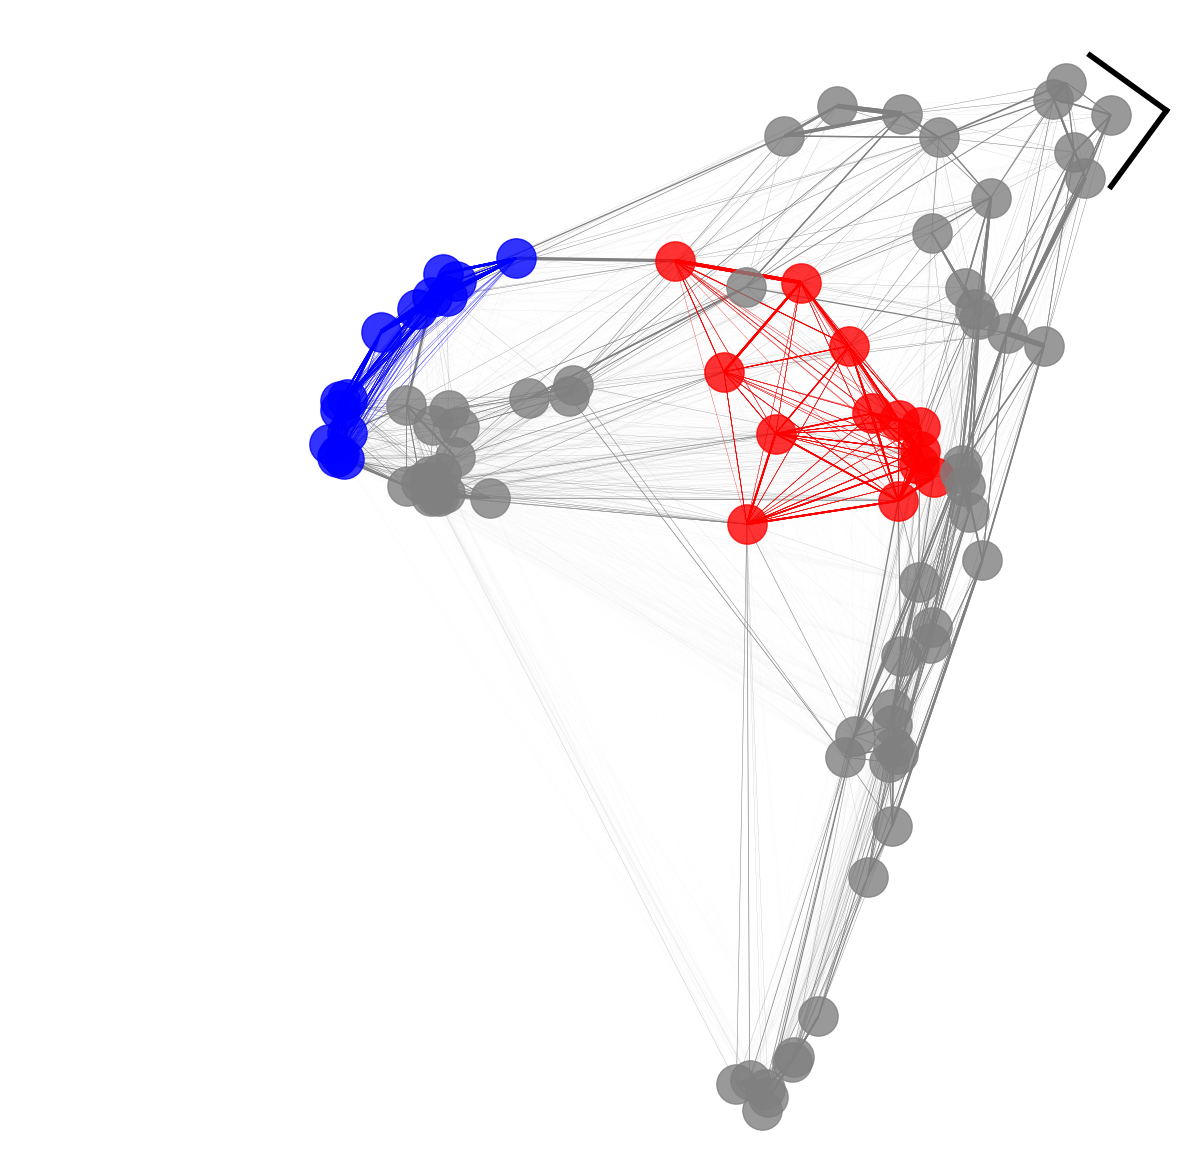

In [8]:
areas = pickle.load(open('generated_data/clustered_areas.p','rb'))

t= 0 
mat_ord = mat#np.arrange([[mat[i,j] for j in ind_rank] for i in ind_rank])
G = nx.from_numpy_array(mat_ord)
#partition = community_louvain.best_partition(G)

edges = G.edges()


rotation = lambda x: np.array([[np.cos(x), -np.sin(x)], [np.sin(x), np.cos(x)]])
psi_rot = lambda x:np.einsum('ij,lj->li', rotation(x), psi(t)[:, 1:3])



theta =   (4 * np.pi)/5.



pos = {}
for l in range(89):
    #pos[l]= (psi(t)[l,1].real,psi(t)[l,2].real)  # positions for all nodes
    pos[l]= (psi_rot(theta)[l, 0].real, psi_rot(theta)[l,1].real) 
M = G.number_of_edges()

origin_x = -.07
origin_y = -.26
x = np.array([np.linspace(0, .04, 1000) + origin_x, origin_y *  np.ones(1000)]) 
y = np.array([ origin_x * np.ones(1000), np.linspace(0, .04, 1000) + origin_y ]) 

x_axis = np.einsum('ij,jl->li',rotation(theta), x) 
y_axis = np.einsum('ij,jl->li',rotation(theta), y) 



fig, ax = plt.subplots(figsize = (15,15))

# nodes
all_nodes = [x for x in range(89)]
#colors = plt.cm.tab10()
#colors = ['b','r','g','m','c','orange','cyan','y','gray','k']
count = 0
for com in set(partition.values()) :
    count = count + 1
    list_nodes = [int(nodes) for nodes in partition.keys() if partition[nodes] == com]
    if count == 2:
        node_color = 'red'
    elif count == 7:
        node_color = 'blue'
    else:
        node_color = 'gray'
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 800, node_color =  [node_color], alpha = 0.8)
    list_edges = [x for x in itertools.product(all_nodes,list_nodes)]
    all_nodes = [x for x in all_nodes if x not in list_nodes]
    weights = [4 * (G[u][v]['weight']-np.min(mat))/(np.max(mat)-np.min(mat)) for u,v in list_edges]
    nx.draw_networkx_edges(G,pos,edgelist=list_edges,width=weights,edge_color='gray')

list_nodes1 = [int(nodes) for nodes in partition.keys() if partition[nodes] == 1]
list_nodes2 = [int(nodes) for nodes in partition.keys() if partition[nodes] == 1]
list_edges = [x for x in itertools.product(list_nodes1,list_nodes2)]
list_edges = list_edges + [x for x in itertools.product(list_nodes2,list_nodes1)]
weights = [4 * (G[u][v]['weight']-np.min(mat))/(np.max(mat)-np.min(mat))+.05 for u,v in list_edges]
nx.draw_networkx_edges(G,pos,edgelist=list_edges,width=weights,edge_color='red')

list_nodes1 = [int(nodes) for nodes in partition.keys() if partition[nodes] == 6]
list_nodes2 = [int(nodes) for nodes in partition.keys() if partition[nodes] == 6]
list_edges = [x for x in itertools.product(list_nodes1,list_nodes2)]
list_edges = list_edges + [x for x in itertools.product(list_nodes2,list_nodes1)]
weights = [4 * (G[u][v]['weight']-np.min(mat))/(np.max(mat)-np.min(mat))+.05 for u,v in list_edges]
nx.draw_networkx_edges(G,pos,edgelist=list_edges,width=weights,edge_color='blue')

#nx.draw_networkx_edges(G, pos,
 #   width=weights *4
                               
#)
#edges[0].set_alpha(1)

# some math labels
#labels = {}
#for l in range(0,89):
#    labels[l] = cortex_acr[l]

#nx.draw_networkx_labels(G, pos, labels, font_size=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
x_min = np.min(psi(t)[:,1].real)
x_max = np.max(psi(t)[:,1].real)
ax.set_xlim([-.28, .212])
ax.set_ylim([-.28, .212])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.plot(x_axis[:, 0], x_axis[:, 1], color = 'k', lw = 4)
ax.plot(y_axis[:, 0], y_axis[:, 1], color = 'k', lw = 4)
#plt.savefig('figures/higher_vision_association.png',bbox_inches = 'tight')


0
1
2
3
4
5
6


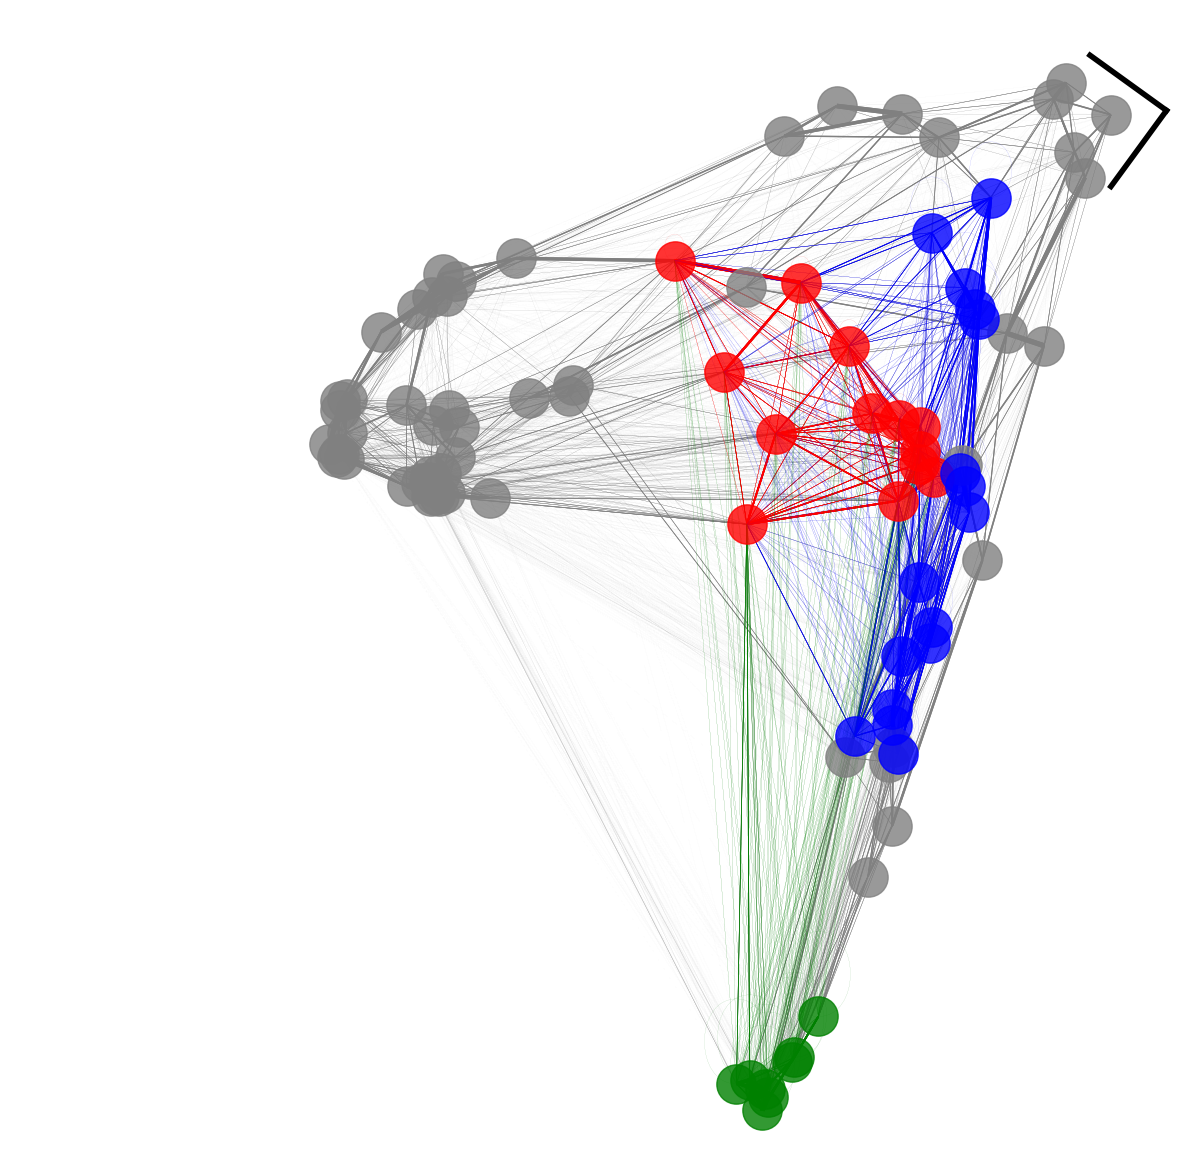

In [9]:
areas = pickle.load(open('generated_data/clustered_areas.p','rb'))

t= 0 
mat_ord = mat#np.arrange([[mat[i,j] for j in ind_rank] for i in ind_rank])
G = nx.from_numpy_array(mat_ord)
#partition = community_louvain.best_partition(G)

edges = G.edges()


rotation = lambda x: np.array([[np.cos(x), -np.sin(x)], [np.sin(x), np.cos(x)]])
psi_rot = lambda x:np.einsum('ij,lj->li', rotation(x), psi(t)[:, 1:3])



theta =   (4 * np.pi)/5.



pos = {}
for l in range(89):
    #pos[l]= (psi(t)[l,1].real,psi(t)[l,2].real)  # positions for all nodes
    pos[l]= (psi_rot(theta)[l, 0].real, psi_rot(theta)[l,1].real) 
M = G.number_of_edges()

origin_x = -.07
origin_y = -.26
x = np.array([np.linspace(0, .04, 1000) + origin_x, origin_y *  np.ones(1000)]) 
y = np.array([ origin_x * np.ones(1000), np.linspace(0, .04, 1000) + origin_y ]) 

x_axis = np.einsum('ij,jl->li',rotation(theta), x) 
y_axis = np.einsum('ij,jl->li',rotation(theta), y) 



fig, ax = plt.subplots(figsize = (15,15))

# nodes
all_nodes = [x for x in range(89)]
#colors = plt.cm.tab10()
#colors = ['b','r','g','m','c','orange','cyan','y','gray','k']
count = 0
for com in set(partition.values()) :
    print(com)
    count = count + 1
    list_nodes = [int(nodes) for nodes in partition.keys() if partition[nodes] == com]
    if count == 2:
        node_color = 'red'
    elif count == 3:
        node_color = 'blue'
    elif count == 5:
        node_color = 'green'
    else:
        node_color = 'gray'
    
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 800, node_color =  [node_color], alpha = 0.8)
    list_edges = [x for x in itertools.product(all_nodes,list_nodes)]
    #all_nodes = [x for x in all_nodes if x not in list_nodes]
    weights = [4 * (G[u][v]['weight']-np.min(mat))/(np.max(mat)-np.min(mat)) for u,v in list_edges]
    nx.draw_networkx_edges(G,pos,edgelist=list_edges,width=weights,edge_color='gray')


list_nodes1 = [int(nodes) for nodes in partition.keys() if partition[nodes] == 1]
list_nodes2 = [int(nodes) for nodes in partition.keys() if partition[nodes] == 1]
list_edges = [x for x in itertools.product(list_nodes1,list_nodes2)]
list_edges = list_edges + [x for x in itertools.product(list_nodes2,list_nodes1)]
weights = [4 * (G[u][v]['weight']-np.min(mat))/(np.max(mat)-np.min(mat))+.05 for u,v in list_edges]
nx.draw_networkx_edges(G,pos,edgelist=list_edges,width=weights,edge_color='red')


list_nodes1 = [int(nodes) for nodes in partition.keys() if partition[nodes] == 2]
list_nodes2 = [int(nodes) for nodes in partition.keys() if partition[nodes] == 1]
list_edges = [x for x in itertools.product(list_nodes1,list_nodes2)]
list_edges = list_edges + [x for x in itertools.product(list_nodes2,list_nodes1)]
list_edges = list_edges + [x for x in itertools.product(list_nodes1,list_nodes1)]
weights = [4 * (G[u][v]['weight']-np.min(mat))/(np.max(mat)-np.min(mat))+.05 for u,v in list_edges]
nx.draw_networkx_edges(G,pos,edgelist=list_edges,width=weights,edge_color='blue')



list_nodes1 = [int(nodes) for nodes in partition.keys() if partition[nodes] == 4]
list_nodes2 = [int(nodes) for nodes in partition.keys() if partition[nodes] == 1]
list_edges = [x for x in itertools.product(list_nodes1,list_nodes2)]
list_edges = list_edges + [x for x in itertools.product(list_nodes2,list_nodes1)]
list_edges = list_edges + [x for x in itertools.product(list_nodes1,list_nodes1)]
weights = [4 * (G[u][v]['weight']-np.min(mat))/(np.max(mat)-np.min(mat))+.05 for u,v in list_edges]
nx.draw_networkx_edges(G,pos,edgelist=list_edges,width=weights,edge_color='green')
#nx.draw_networkx_edges(G, pos,
 #   width=weights *4
                               
#)
#edges[0].set_alpha(1)

# some math labels
#labels = {}
#for l in range(0,89):
#    labels[l] = cortex_acr[l]

#nx.draw_networkx_labels(G, pos, labels, font_size=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
x_min = np.min(psi(t)[:,1].real)
x_max = np.max(psi(t)[:,1].real)
ax.set_xlim([-.28, .212])
ax.set_ylim([-.28, .212])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.plot(x_axis[:, 0], x_axis[:, 1], color = 'k', lw = 4)
ax.plot(y_axis[:, 0], y_axis[:, 1], color = 'k', lw = 4)
plt.savefig('figures/pfc_control_attractors.png',bbox_inches = 'tight')

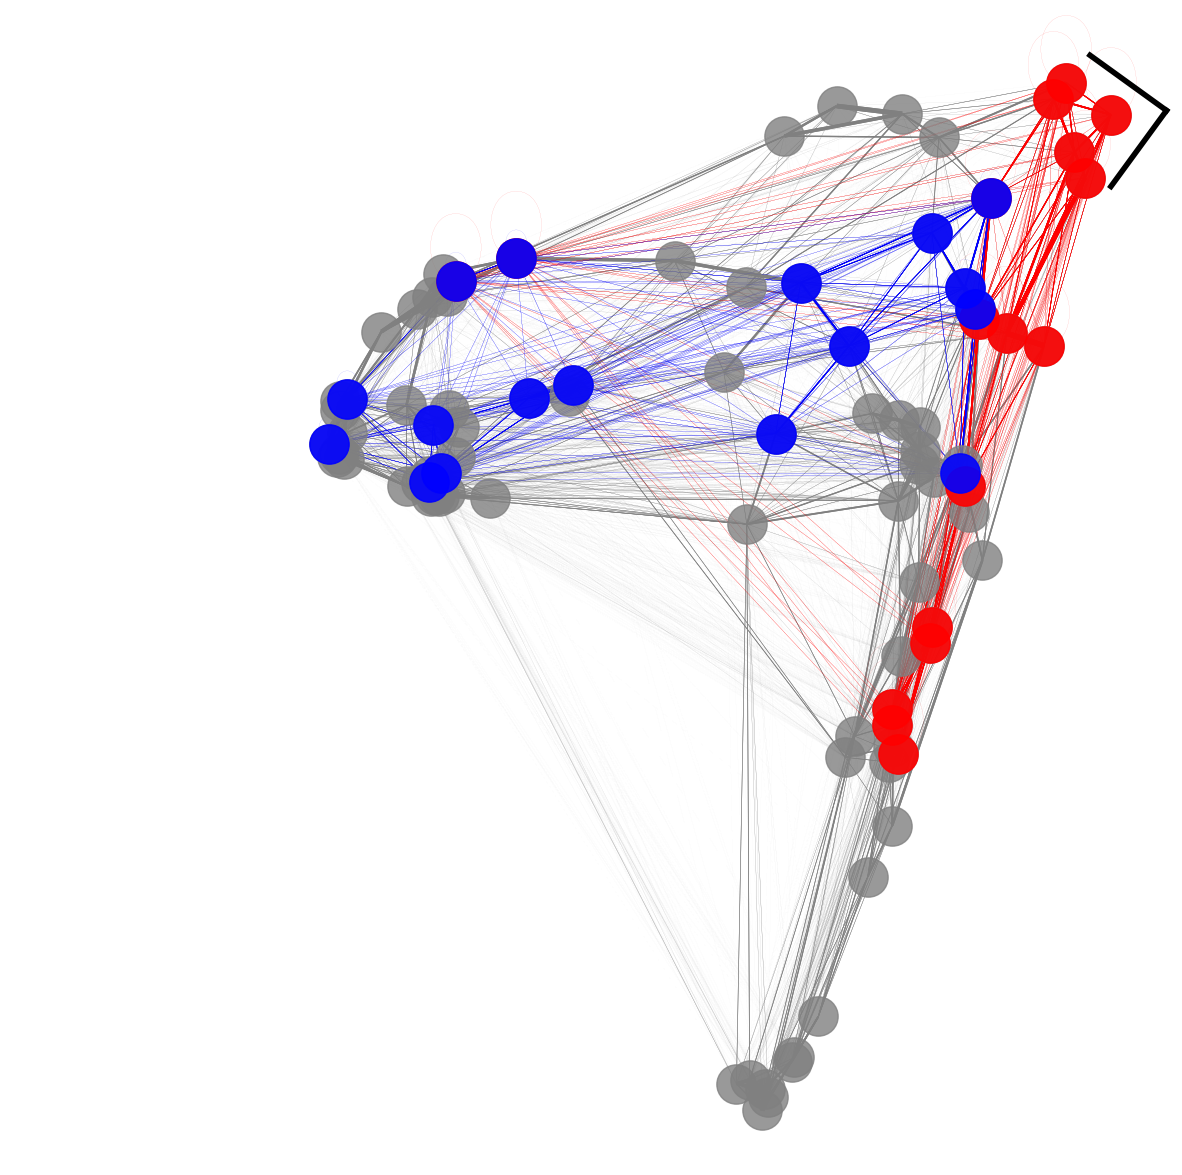

In [10]:
areas = pickle.load(open('data_connectivity/cognitive_subnetworks.p','rb'))

t= 0 
mat_ord = mat#np.arrange([[mat[i,j] for j in ind_rank] for i in ind_rank])
G = nx.from_numpy_array(mat_ord)
#partition = community_louvain.best_partition(G)

edges = G.edges()


rotation = lambda x: np.array([[np.cos(x), -np.sin(x)], [np.sin(x), np.cos(x)]])
psi_rot = lambda x:np.einsum('ij,lj->li', rotation(x), psi(t)[:, 1:3])



theta =   (4 * np.pi)/5.



pos = {}
for l in range(89):
    #pos[l]= (psi(t)[l,1].real,psi(t)[l,2].real)  # positions for all nodes
    pos[l]= (psi_rot(theta)[l, 0].real, psi_rot(theta)[l,1].real) 
M = G.number_of_edges()

origin_x = -.07
origin_y = -.26
x = np.array([np.linspace(0, .04, 1000) + origin_x, origin_y *  np.ones(1000)]) 
y = np.array([ origin_x * np.ones(1000), np.linspace(0, .04, 1000) + origin_y ]) 

x_axis = np.einsum('ij,jl->li',rotation(theta), x) 
y_axis = np.einsum('ij,jl->li',rotation(theta), y) 



fig, ax = plt.subplots(figsize = (15,15))

# nodes
all_nodes = [x for x in range(89)]
#colors = plt.cm.tab10()
#colors = ['b','r','g','m','c','orange','cyan','y','gray','k']
count = 0

#all_nodes
list_nodes = all_nodes
node_color = 'gray'
alpha2 = 0.8
nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 800, node_color =  [node_color], alpha = alpha2)
list_edges = [x for x in itertools.product(all_nodes,list_nodes)]
#all_nodes = [x for x in all_nodes if x not in list_nodes]
weights = [4 * (G[u][v]['weight']-np.min(mat))/(np.max(mat)-np.min(mat)) for u,v in list_edges]
nx.draw_networkx_edges(G,pos,edgelist=list_edges,width=weights,edge_color='gray')


#FPN
alpha = .9
list_nodes = areas['DorsAtt']
node_color = 'red'#(221/255., 88/255., 17/255.)
nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 800, node_color =  [node_color], alpha = alpha)
list_edges = [x for x in itertools.product(all_nodes,list_nodes)]
#all_nodes = [x for x in all_nodes if x not in list_nodes]



list_nodes1 = list_nodes
list_nodes2 = list_nodes
list_edges = [x for x in itertools.product(list_nodes1,list_nodes2)]
list_edges = list_edges + [x for x in itertools.product(list_nodes2,list_nodes1)]
weights = [4 * (G[u][v]['weight']-np.min(mat))/(np.max(mat)-np.min(mat))+.05 for u,v in list_edges]
nx.draw_networkx_edges(G,pos,edgelist=list_edges,width=weights,edge_color=node_color)

# Salience
list_nodes = areas['Salience']
node_color = 'blue'#(17/255., 150/255., 221/255.)
nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 800, node_color =  [node_color], alpha = alpha)
list_edges = [x for x in itertools.product(all_nodes,list_nodes)]
#all_nodes = [x for x in all_nodes if x not in list_nodes]


list_nodes1 = list_nodes
list_nodes2 = list_nodes
list_edges = [x for x in itertools.product(list_nodes1,list_nodes2)]
list_edges = list_edges + [x for x in itertools.product(list_nodes2,list_nodes1)]
weights = [4 * (G[u][v]['weight']-np.min(mat))/(np.max(mat)-np.min(mat))+.05 for u,v in list_edges]
nx.draw_networkx_edges(G,pos,edgelist=list_edges,width=weights,edge_color=node_color)


#nx.draw_networkx_edges(G, pos,
 #   width=weights *4
                               
#)
#edges[0].set_alpha(1)

# some math labels
#labels = {}
#for l in range(0,89):
#    labels[l] = cortex_acr[l]

#nx.draw_networkx_labels(G, pos, labels, font_size=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
x_min = np.min(psi(t)[:,1].real)
x_max = np.max(psi(t)[:,1].real)
ax.set_xlim([-.28, .212])
ax.set_ylim([-.28, .212])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.plot(x_axis[:, 0], x_axis[:, 1], color = 'k', lw = 4)
ax.plot(y_axis[:, 0], y_axis[:, 1], color = 'k', lw = 4)

plt.savefig('figures/dan_salience.png',bbox_inches = 'tight')

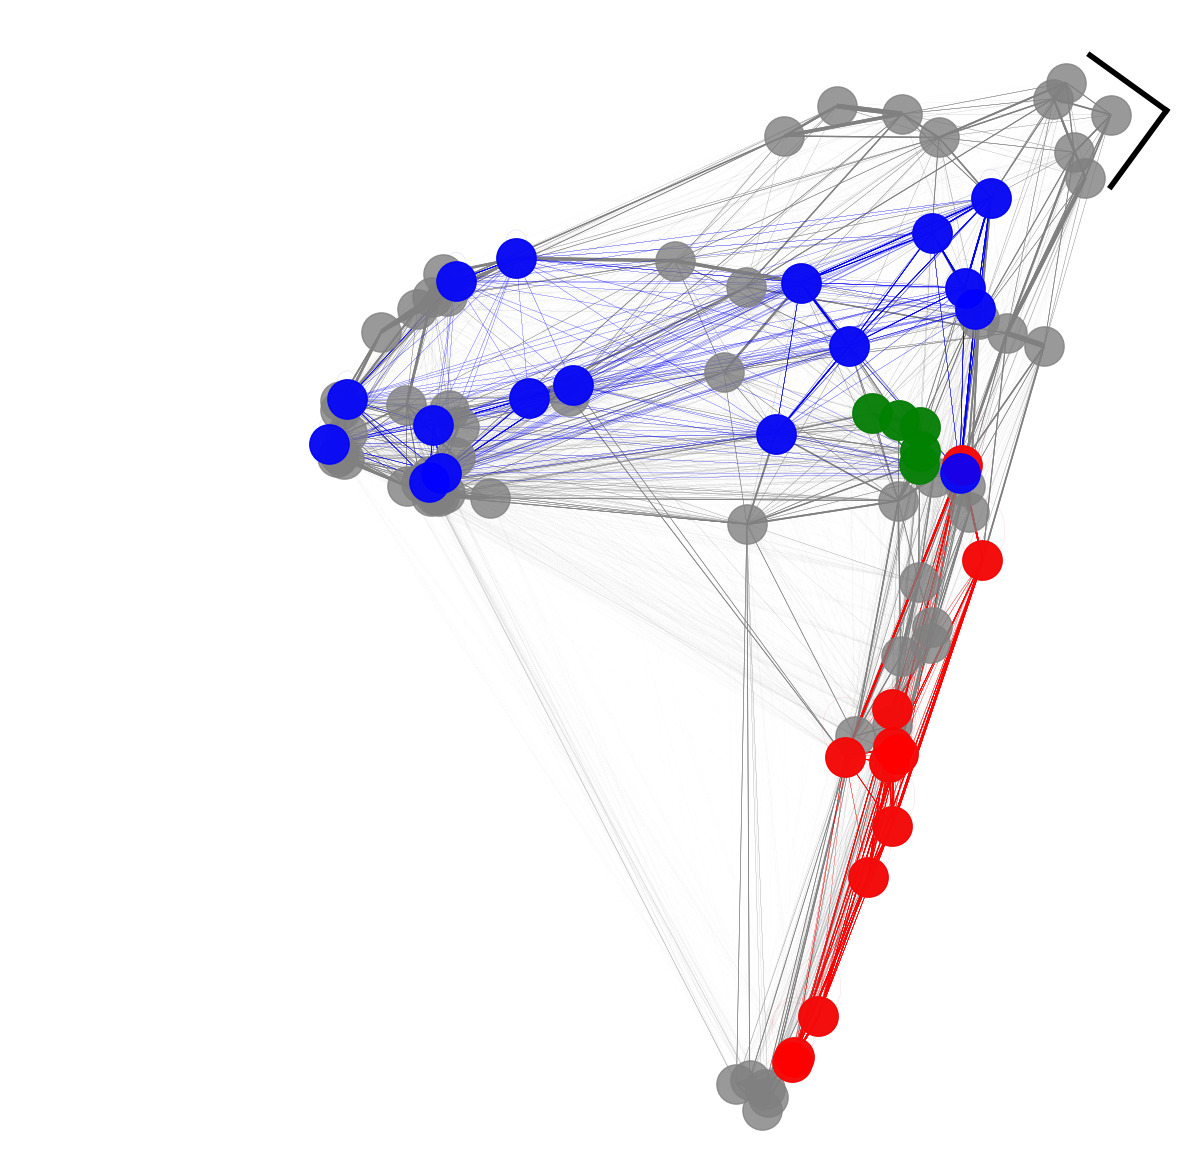

In [11]:
areas = pickle.load(open('data_connectivity/cognitive_subnetworks.p','rb'))
auditory = pickle.load(open('data_connectivity/autiory_subnetwork.p','rb'))

t= 0 
mat_ord = mat#np.arrange([[mat[i,j] for j in ind_rank] for i in ind_rank])
G = nx.from_numpy_array(mat_ord)
#partition = community_louvain.best_partition(G)

edges = G.edges()


rotation = lambda x: np.array([[np.cos(x), -np.sin(x)], [np.sin(x), np.cos(x)]])
psi_rot = lambda x:np.einsum('ij,lj->li', rotation(x), psi(t)[:, 1:3])



theta =   (4 * np.pi)/5.



pos = {}
for l in range(89):
    #pos[l]= (psi(t)[l,1].real,psi(t)[l,2].real)  # positions for all nodes
    pos[l]= (psi_rot(theta)[l, 0].real, psi_rot(theta)[l,1].real) 
M = G.number_of_edges()

origin_x = -.07
origin_y = -.26
x = np.array([np.linspace(0, .04, 1000) + origin_x, origin_y *  np.ones(1000)]) 
y = np.array([ origin_x * np.ones(1000), np.linspace(0, .04, 1000) + origin_y ]) 

x_axis = np.einsum('ij,jl->li',rotation(theta), x) 
y_axis = np.einsum('ij,jl->li',rotation(theta), y) 



fig, ax = plt.subplots(figsize = (15,15))

# nodes
all_nodes = [x for x in range(89)]
#colors = plt.cm.tab10()
#colors = ['b','r','g','m','c','orange','cyan','y','gray','k']
count = 0

#all_nodes
list_nodes = all_nodes
node_color = 'gray'
alpha2 = 0.8
nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 800, node_color =  [node_color], alpha = alpha2)
list_edges = [x for x in itertools.product(all_nodes,list_nodes)]
#all_nodes = [x for x in all_nodes if x not in list_nodes]
weights = [4 * (G[u][v]['weight']-np.min(mat))/(np.max(mat)-np.min(mat)) for u,v in list_edges]
nx.draw_networkx_edges(G,pos,edgelist=list_edges,width=weights,edge_color='gray')


#FPN
alpha = .9
list_nodes = areas['Visual']
node_color = 'red'#(221/255., 88/255., 17/255.)
nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 800, node_color =  [node_color], alpha = alpha)
list_edges = [x for x in itertools.product(all_nodes,list_nodes)]
#all_nodes = [x for x in all_nodes if x not in list_nodes]



list_nodes1 = list_nodes
list_nodes2 = list_nodes
list_edges = [x for x in itertools.product(list_nodes1,list_nodes2)]
list_edges = list_edges + [x for x in itertools.product(list_nodes2,list_nodes1)]
weights = [4 * (G[u][v]['weight']-np.min(mat))/(np.max(mat)-np.min(mat))+.05 for u,v in list_edges]
nx.draw_networkx_edges(G,pos,edgelist=list_edges,width=weights,edge_color=node_color)

# Salience
list_nodes = areas['Salience']
node_color = 'blue'#(17/255., 150/255., 221/255.)
nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 800, node_color =  [node_color], alpha = alpha)
list_edges = [x for x in itertools.product(all_nodes,list_nodes)]
#all_nodes = [x for x in all_nodes if x not in list_nodes]


list_nodes1 = list_nodes
list_nodes2 = list_nodes
list_edges = [x for x in itertools.product(list_nodes1,list_nodes2)]
list_edges = list_edges + [x for x in itertools.product(list_nodes2,list_nodes1)]
weights = [4 * (G[u][v]['weight']-np.min(mat))/(np.max(mat)-np.min(mat))+.05 for u,v in list_edges]
nx.draw_networkx_edges(G,pos,edgelist=list_edges,width=weights,edge_color=node_color)



# Salience
list_nodes = auditory
node_color = 'green'#(17/255., 150/255., 221/255.)
nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 800, node_color =  [node_color], alpha = alpha)
list_edges = [x for x in itertools.product(all_nodes,list_nodes)]
#all_nodes = [x for x in all_nodes if x not in list_nodes]


list_nodes1 = list_nodes
list_nodes2 = list_nodes
list_edges = [x for x in itertools.product(list_nodes1,list_nodes2)]
list_edges = list_edges + [x for x in itertools.product(list_nodes2,list_nodes1)]
weights = [4 * (G[u][v]['weight']-np.min(mat))/(np.max(mat)-np.min(mat))+.05 for u,v in list_edges]
nx.draw_networkx_edges(G,pos,edgelist=list_edges,width=weights,edge_color=node_color)

#nx.draw_networkx_edges(G, pos,
 #   width=weights *4
                               
#)
#edges[0].set_alpha(1)

# some math labels
#labels = {}
#for l in range(0,89):
#    labels[l] = cortex_acr[l]

#nx.draw_networkx_labels(G, pos, labels, font_size=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
x_min = np.min(psi(t)[:,1].real)
x_max = np.max(psi(t)[:,1].real)
ax.set_xlim([-.28, .212])
ax.set_ylim([-.28, .212])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.plot(x_axis[:, 0], x_axis[:, 1], color = 'k', lw = 4)
ax.plot(y_axis[:, 0], y_axis[:, 1], color = 'k', lw = 4)

plt.savefig('figures/visual_auditory_salience.png',bbox_inches = 'tight')

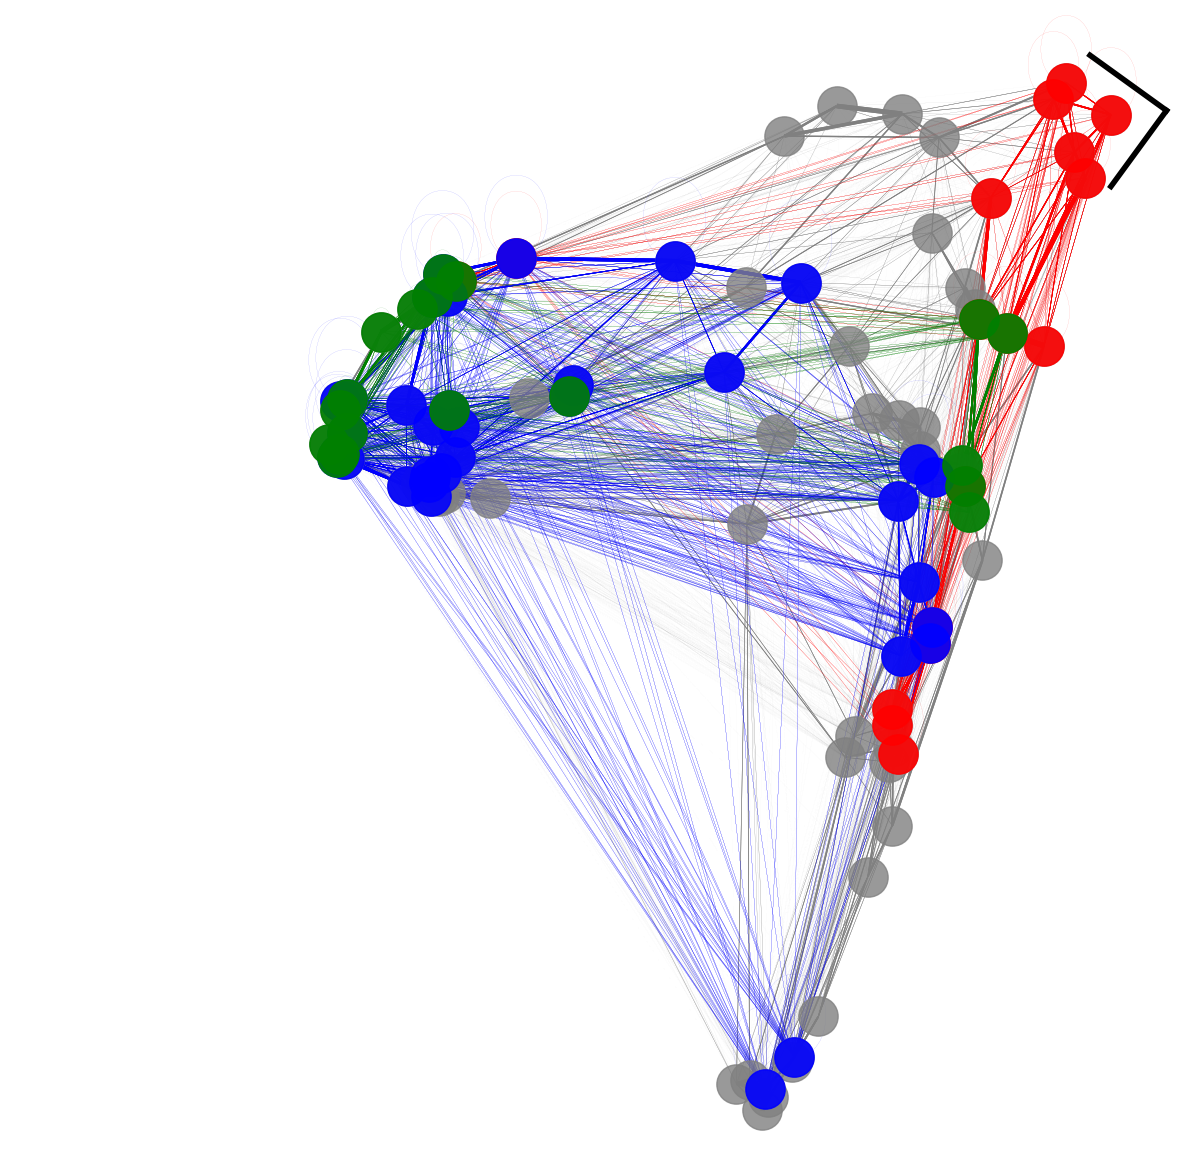

In [14]:
areas = pickle.load(open('data_connectivity/cognitive_subnetworks.p','rb'))
auditory = pickle.load(open('data_connectivity/autiory_subnetwork.p','rb'))

t= 0 
mat_ord = mat#np.arrange([[mat[i,j] for j in ind_rank] for i in ind_rank])
G = nx.from_numpy_array(mat_ord)
#partition = community_louvain.best_partition(G)

edges = G.edges()


rotation = lambda x: np.array([[np.cos(x), -np.sin(x)], [np.sin(x), np.cos(x)]])
psi_rot = lambda x:np.einsum('ij,lj->li', rotation(x), psi(t)[:, 1:3])



theta =   (4 * np.pi)/5.



pos = {}
for l in range(89):
    #pos[l]= (psi(t)[l,1].real,psi(t)[l,2].real)  # positions for all nodes
    pos[l]= (psi_rot(theta)[l, 0].real, psi_rot(theta)[l,1].real) 
M = G.number_of_edges()

origin_x = -.07
origin_y = -.26
x = np.array([np.linspace(0, .04, 1000) + origin_x, origin_y *  np.ones(1000)]) 
y = np.array([ origin_x * np.ones(1000), np.linspace(0, .04, 1000) + origin_y ]) 

x_axis = np.einsum('ij,jl->li',rotation(theta), x) 
y_axis = np.einsum('ij,jl->li',rotation(theta), y) 



fig, ax = plt.subplots(figsize = (15,15))

# nodes
all_nodes = [x for x in range(89)]
#colors = plt.cm.tab10()
#colors = ['b','r','g','m','c','orange','cyan','y','gray','k']
count = 0

#all_nodes
list_nodes = all_nodes
node_color = 'gray'
alpha2 = 0.8
nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 800, node_color =  [node_color], alpha = alpha2)
list_edges = [x for x in itertools.product(all_nodes,list_nodes)]
#all_nodes = [x for x in all_nodes if x not in list_nodes]
weights = [4 * (G[u][v]['weight']-np.min(mat))/(np.max(mat)-np.min(mat)) for u,v in list_edges]
nx.draw_networkx_edges(G,pos,edgelist=list_edges,width=weights,edge_color='gray')


#FPN
alpha = .9
list_nodes = areas['DorsAtt']
node_color = 'red'#(221/255., 88/255., 17/255.)
nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 800, node_color =  [node_color], alpha = alpha)
list_edges = [x for x in itertools.product(all_nodes,list_nodes)]
#all_nodes = [x for x in all_nodes if x not in list_nodes]



list_nodes1 = list_nodes
list_nodes2 = list_nodes
list_edges = [x for x in itertools.product(list_nodes1,list_nodes2)]
list_edges = list_edges + [x for x in itertools.product(list_nodes2,list_nodes1)]
weights = [4 * (G[u][v]['weight']-np.min(mat))/(np.max(mat)-np.min(mat))+.05 for u,v in list_edges]
nx.draw_networkx_edges(G,pos,edgelist=list_edges,width=weights,edge_color=node_color)

# Salience
list_nodes = areas['Default']
node_color = 'blue'#(17/255., 150/255., 221/255.)
nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 800, node_color =  [node_color], alpha = alpha)
list_edges = [x for x in itertools.product(all_nodes,list_nodes)]
#all_nodes = [x for x in all_nodes if x not in list_nodes]


list_nodes1 = list_nodes
list_nodes2 = list_nodes
list_edges = [x for x in itertools.product(list_nodes1,list_nodes2)]
list_edges = list_edges + [x for x in itertools.product(list_nodes2,list_nodes1)]
weights = [4 * (G[u][v]['weight']-np.min(mat))/(np.max(mat)-np.min(mat))+.05 for u,v in list_edges]
nx.draw_networkx_edges(G,pos,edgelist=list_edges,width=weights,edge_color=node_color)



# Salience
list_nodes = areas['FPN']
node_color = 'green'#(17/255., 150/255., 221/255.)
nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 800, node_color =  [node_color], alpha = alpha)
list_edges = [x for x in itertools.product(all_nodes,list_nodes)]
#all_nodes = [x for x in all_nodes if x not in list_nodes]


list_nodes1 = list_nodes
list_nodes2 = list_nodes
list_edges = [x for x in itertools.product(list_nodes1,list_nodes2)]
list_edges = list_edges + [x for x in itertools.product(list_nodes2,list_nodes1)]
weights = [4 * (G[u][v]['weight']-np.min(mat))/(np.max(mat)-np.min(mat))+.05 for u,v in list_edges]
nx.draw_networkx_edges(G,pos,edgelist=list_edges,width=weights,edge_color=node_color)

#nx.draw_networkx_edges(G, pos,
 #   width=weights *4
                               
#)
#edges[0].set_alpha(1)

# some math labels
#labels = {}
#for l in range(0,89):
#    labels[l] = cortex_acr[l]

#nx.draw_networkx_labels(G, pos, labels, font_size=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
x_min = np.min(psi(t)[:,1].real)
x_max = np.max(psi(t)[:,1].real)
ax.set_xlim([-.28, .212])
ax.set_ylim([-.28, .212])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.plot(x_axis[:, 0], x_axis[:, 1], color = 'k', lw = 4)
ax.plot(y_axis[:, 0], y_axis[:, 1], color = 'k', lw = 4)

plt.savefig('figures/dmn_dan_fpn.png',bbox_inches = 'tight')

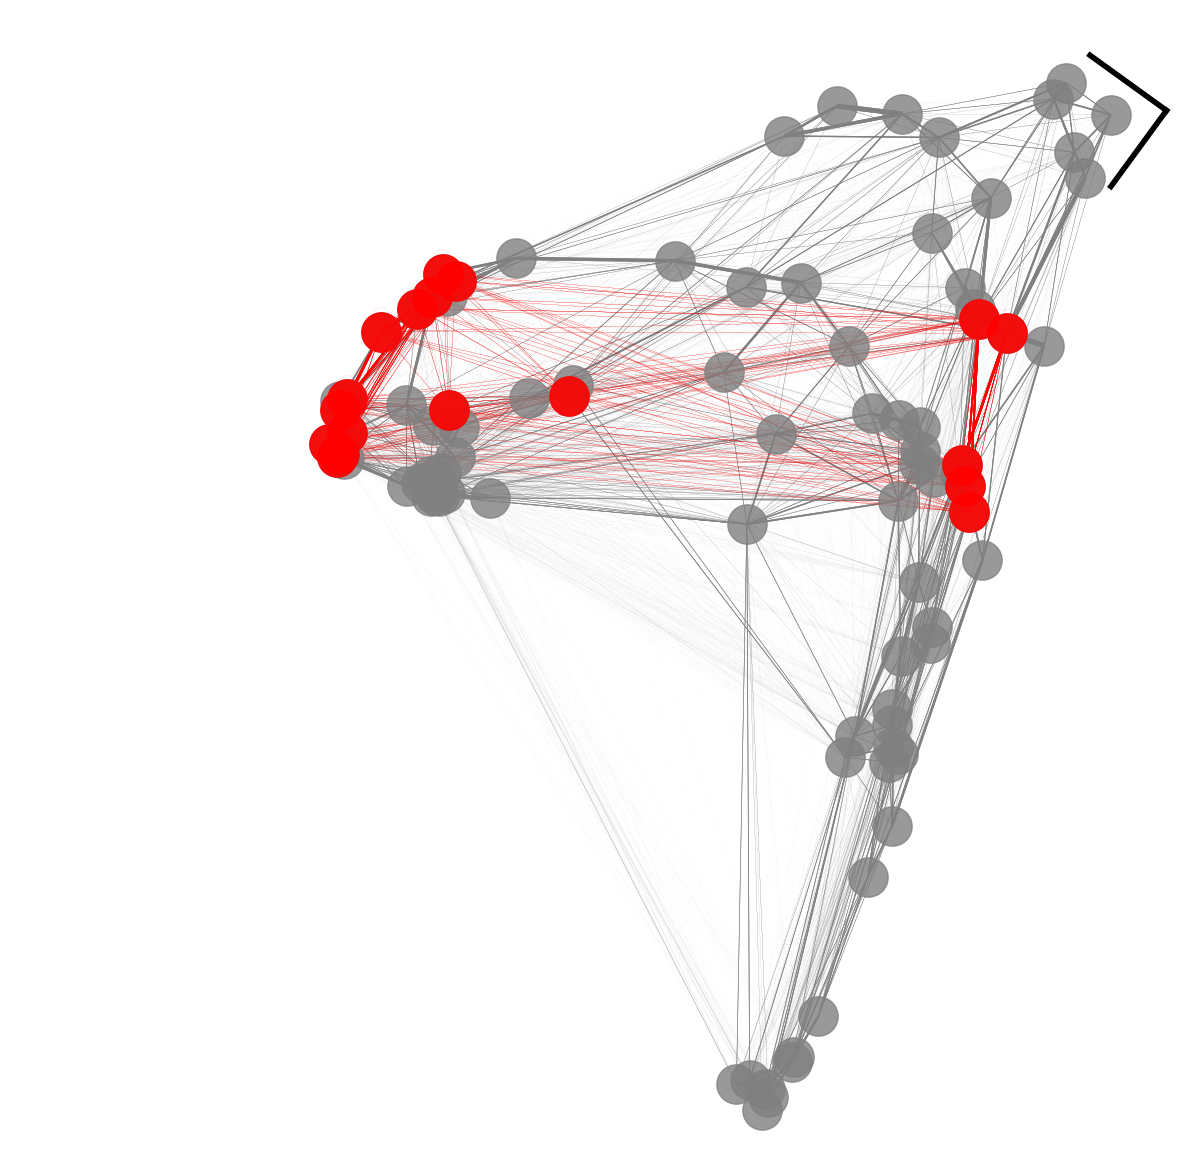

In [9]:
areas = pickle.load(open('data_connectivity/cognitive_subnetworks.p','rb'))
auditory = pickle.load(open('data_connectivity/autiory_subnetwork.p','rb'))

t= 0 
mat_ord = mat#np.arrange([[mat[i,j] for j in ind_rank] for i in ind_rank])
G = nx.from_numpy_array(mat_ord)
#partition = community_louvain.best_partition(G)

edges = G.edges()


rotation = lambda x: np.array([[np.cos(x), -np.sin(x)], [np.sin(x), np.cos(x)]])
psi_rot = lambda x:np.einsum('ij,lj->li', rotation(x), psi(t)[:, 1:3])



theta =   (4 * np.pi)/5.



pos = {}
for l in range(89):
    #pos[l]= (psi(t)[l,1].real,psi(t)[l,2].real)  # positions for all nodes
    pos[l]= (psi_rot(theta)[l, 0].real, psi_rot(theta)[l,1].real) 
M = G.number_of_edges()

origin_x = -.07
origin_y = -.26
x = np.array([np.linspace(0, .04, 1000) + origin_x, origin_y *  np.ones(1000)]) 
y = np.array([ origin_x * np.ones(1000), np.linspace(0, .04, 1000) + origin_y ]) 

x_axis = np.einsum('ij,jl->li',rotation(theta), x) 
y_axis = np.einsum('ij,jl->li',rotation(theta), y) 



fig, ax = plt.subplots(figsize = (15,15))

# nodes
all_nodes = [x for x in range(89)]
#colors = plt.cm.tab10()
#colors = ['b','r','g','m','c','orange','cyan','y','gray','k']
count = 0

#all_nodes
list_nodes = all_nodes
node_color = 'gray'
alpha2 = 0.8
nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 800, node_color =  [node_color], alpha = alpha2)
list_edges = [x for x in itertools.product(all_nodes,list_nodes)]
#all_nodes = [x for x in all_nodes if x not in list_nodes]
weights = [4 * (G[u][v]['weight']-np.min(mat))/(np.max(mat)-np.min(mat)) for u,v in list_edges]
nx.draw_networkx_edges(G,pos,edgelist=list_edges,width=weights,edge_color='gray')


# FPN
list_nodes = areas['FPN']
node_color = 'red'#(17/255., 150/255., 221/255.)
nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 800, node_color =  [node_color], alpha = alpha)
list_edges = [x for x in itertools.product(all_nodes,list_nodes)]
#all_nodes = [x for x in all_nodes if x not in list_nodes]


list_nodes1 = list_nodes
list_nodes2 = list_nodes
list_edges = [x for x in itertools.product(list_nodes1,list_nodes2)]
list_edges = list_edges + [x for x in itertools.product(list_nodes2,list_nodes1)]
weights = [4 * (G[u][v]['weight']-np.min(mat))/(np.max(mat)-np.min(mat))+.05 for u,v in list_edges]
nx.draw_networkx_edges(G,pos,edgelist=list_edges,width=weights,edge_color=node_color)

#nx.draw_networkx_edges(G, pos,
 #   width=weights *4
                               
#)
#edges[0].set_alpha(1)

# some math labels
#labels = {}
#for l in range(0,89):
#    labels[l] = cortex_acr[l]

#nx.draw_networkx_labels(G, pos, labels, font_size=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
x_min = np.min(psi(t)[:,1].real)
x_max = np.max(psi(t)[:,1].real)
ax.set_xlim([-.28, .212])
ax.set_ylim([-.28, .212])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.plot(x_axis[:, 0], x_axis[:, 1], color = 'k', lw = 4)
ax.plot(y_axis[:, 0], y_axis[:, 1], color = 'k', lw = 4)

plt.savefig('figures/fpn_diffusion_map.png',bbox_inches = 'tight')

In [21]:
for l in areas['FPN']:
    print(l, cortex_acr[l])

39 44
71 29/30
24 45B
29 46d
53 46v
23 7a
55 8B
18 8l
14 8m
46 8r
37 9/46d
31 9/46v
9 DP
27 F3
15 F4
34 MST
7 V6
8 V6A
